# Conditional Neural Processes (CNP) for Coherent.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime
import numpy as np
import pandas as pd
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml
# may have to run this cell 2 times for an error to go away

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
with open("../coherent/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_predict"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out  = config_file["path_settings"]["path_out_cnp"]
version   = config_file["path_settings"]["version"]
iteration = config_file["path_settings"]["iteration"]
fidelity  = config_file["path_settings"]["fidelity"]

path_to_files_predict = config_file["path_settings"]["path_to_files_predict"]
if path_to_files_predict == ["../coherent/in/data/validation/lf"]:
    output_suffix = "output_validation"
else:
    output_suffix = "output"

In [5]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])

In [6]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'{path_out}/cnp_{version}_model.pth'))
model.eval()

DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=43, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

Batch :0
2025-10-09 18:33:16 Iteration: 0/0, train loss: 0.6705 (vs BCE 0.3363)


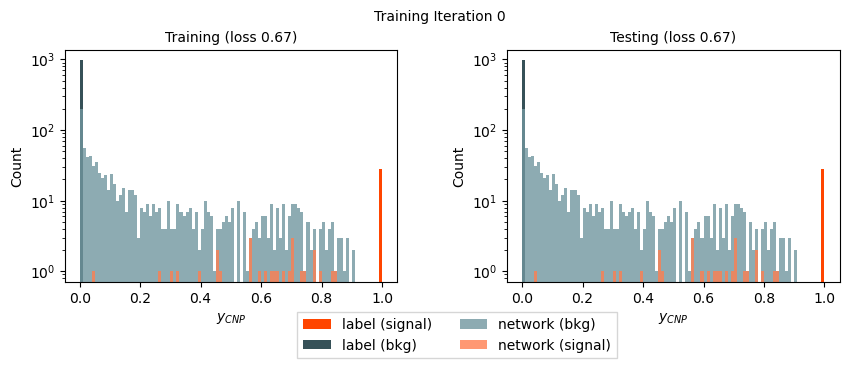

Batch :1
Batch :2
Batch :3
Batch :4
Batch :5
Batch :6
Batch :7
Batch :8
Batch :9
Batch :10
Batch :11
Batch :12
Batch :13
Batch :14
Batch :15
Batch :16
Batch :17
Batch :18
Batch :19
Batch :20
Batch :21
Batch :22
Batch :23
Batch :24
Batch :25
Batch :26
Batch :27
Batch :28
Batch :29
Batch :30
Batch :31
Batch :32
Batch :33
Batch :34
Batch :35
Batch :36
Batch :37
Batch :38
Batch :39
Batch :40
Batch :41
Batch :42
Batch :43
Batch :44
Batch :45
Batch :46
Batch :47
Batch :48
Batch :49
Batch :50
Batch :51
Batch :52
Batch :53
Batch :54
Batch :55
Batch :56
Batch :57
Batch :58
Batch :59
Batch :60
Batch :61
Batch :62
Batch :63
Batch :64
Batch :65
Batch :66
Batch :67
Batch :68
Batch :69
Batch :70
Batch :71
Batch :72
Batch :73
Batch :74
Batch :75
Batch :76
Batch :77
Batch :78
Batch :79
Batch :80
Batch :81
Batch :82
Batch :83
Batch :84
Batch :85
Batch :86
Batch :87
Batch :88
Batch :89
Batch :90
Batch :91
Batch :92
Batch :93
Batch :94
Batch :95
Batch :96
Batch :97
Batch :98
Batch :99
Batch :100
Batch :1

In [7]:
bce = nn.BCELoss()

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_{output_suffix}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader

    # Shuffle the files in the dataset for randomized prediction order
    dataloader_predict.dataset.shuffle_files()

    for b, batch in enumerate(dataloader_predict):
        # Safety check: Skip empty batches
        if batch.numel() == 0:
            print(f"Warning: Skipping empty batch at iteration {b}")
            continue
            
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0].detach().numpy()
        print(f"Batch :{it_batch}")
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_{output_suffix}.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1


Marginalized plots saved to: ../coherent/out/cnp/cnp_v1.0_output.png


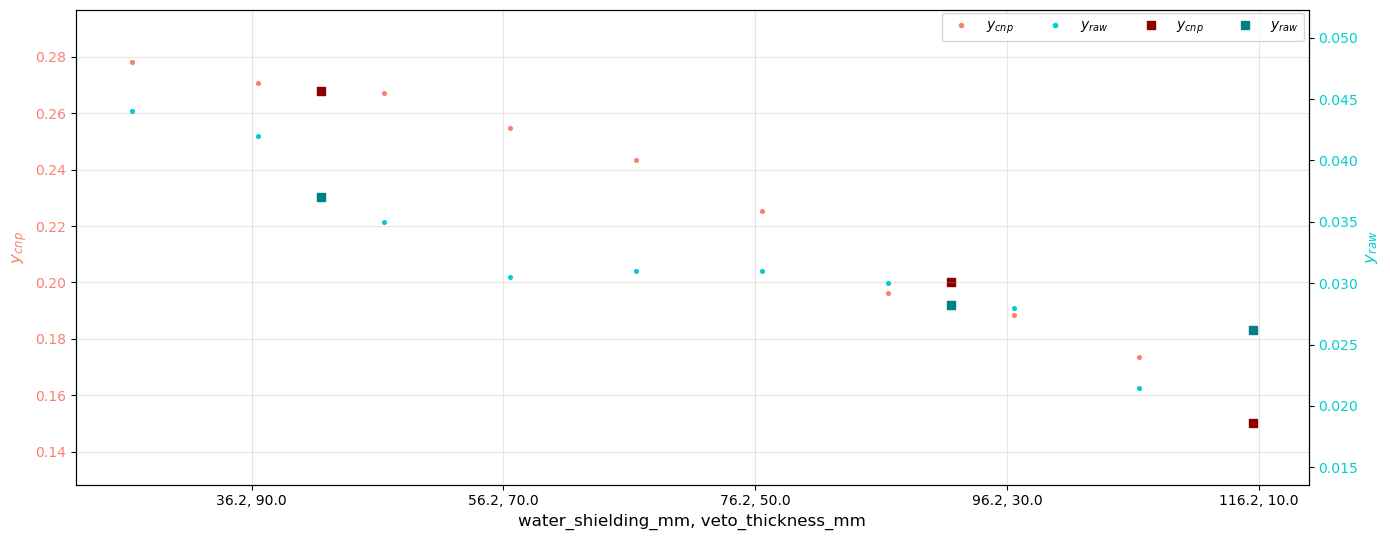

In [8]:
# Generate marginalized plots for all parameters
try:
    fig = plotting.get_marginialized_all(config_file=config_file)
    fig.savefig(f'{path_out}/cnp_{version}_{output_suffix}.png', dpi=300, bbox_inches='tight')
    print(f"Marginalized plots saved to: {path_out}/cnp_{version}_{output_suffix}.png")
except Exception as e:
    print(f"Error generating marginalized plots: {e}")
    import traceback
    traceback.print_exc()